In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [3]:
import pandas as pd
from scipy.stats import zscore
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import math

from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.spatial.distance import cdist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import np_utils
from sklearn.model_selection import KFold
from keras.regularizers import l2

import catboost as cb
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

In [6]:
from google.colab import files
uploaded = files.upload()

Saving covid_data_test.csv to covid_data_test.csv


In [18]:
def z_score_normalizaion_set(data):
  mean = dict()
  std = dict()
  for column in data.columns:
    try:
      mean[column] = data[column].mean()
      std[column] = data[column].std()
      data[column] = (data[column] - mean[column]) / std[column]
    except TypeError:
      continue
  return data, mean, std

def z_score_normalizaion(data, mean, std):
  for column in data.columns:
    try:
      data[column] = (data[column] - mean[column]) / std[column]
    except KeyError:
      continue
  return data

def data_preprocess(data, test=False, mean=None, std=None):
    droplist = ['ekmo_number', 'life_quality_place_rating', 'ecology', 'cleanness', 'public_services', 'neighbourhood', 'children_places', 'sport_and_outdoor',
                'shops_and_malls', 'public_transport', 'security', 'life_costs', 'epirank_avia', 'epirank_train', 'epirank_avia_cat', 'epirank_train_cat']
    """for col in data.columns:
        if data[col].isnull().sum() * 100 / len(data) > 27:
            print(col, data[col].isnull().sum() * 100 / len(data))
            del data[col]"""
    data = data.drop(droplist, axis='columns')
    if test == False:
        rows_and_nan = np.array(data.isnull().sum(axis=1))
        index_to_drop = []
        for i in range(len(rows_and_nan)):
            if rows_and_nan[i] > 20:
                index_to_drop.append(i)
        data = data.drop(data.index[index_to_drop])
        data = data.reset_index()
        data = data.drop(['Unnamed: 0'], axis='columns')
        del data['index']
    else:
        data = data.drop(['inf_rate'], axis='columns')
        data.index = data['Unnamed: 0']
        data = data.drop(['Unnamed: 0'], axis='columns')
    data.fillna(data.mean(), inplace=True)

    data1 = data.copy()
    urban50over_share = data1['urban_50-54_years'] + data1['urban_55-59_years']+ data1['urban_60-64_years'] + data1['urban_65-69_years']
    urban50over_share += data1['urban_70-74_years'] + data1['urban_75-79_years'] + data1['urban_80-84_years'] + data1['urban_85-89_years'] + data1['urban_90-94_years']
    urban50over_share /= data1['urban']
    data1.insert(len(data1.columns), 'urban50over_share', urban50over_share, False)
    data1.insert(len(data1.columns), 'tubercul_share', data1['num_patients_tubercul_2017'] / data1['whole_population'], False)

    droplist0 = ['urban_50-54_years', 'urban_55-59_years', 'urban_60-64_years', 'urban_65-69_years', 'urban_70-74_years', 'urban_75-79_years',
    'urban_80-84_years', 'urban_85-89_years', 'urban_90-94_years', 'rural_50-54_years', 'rural_55-59_years', 'rural_60-64_years',
    'rural_65-69_years', 'rural_70-74_years', 'rural_75-79_years','rural_80-84_years', 'rural_85-89_years', 'rural_90-94_years', 'num_patients_tubercul_1992',
    'num_patients_tubercul_1993', 'num_patients_tubercul_1994', 'num_patients_tubercul_1995', 'num_patients_tubercul_1996',
    'num_patients_tubercul_1997', 'num_patients_tubercul_1998', 'num_patients_tubercul_1999', 'num_patients_tubercul_2000',
    'num_patients_tubercul_2001', 'num_patients_tubercul_2002', 'num_patients_tubercul_2003', 'num_patients_tubercul_2004',
    'num_patients_tubercul_2005', 'num_patients_tubercul_2006', 'num_patients_tubercul_2007', 'num_patients_tubercul_2008',
    'num_patients_tubercul_2009', 'num_patients_tubercul_2010', 'num_patients_tubercul_2011', 'num_patients_tubercul_2012',
    'num_patients_tubercul_2013', 'num_patients_tubercul_2014', 'num_patients_tubercul_2015', 'num_patients_tubercul_2016', 'num_patients_tubercul_2017',
    'name', 'district', 'subject', 'name', 'district', 'avg_temp_min', 'avg_temp_max', 'avg_temp_std', 'humidity_min', 'humidity_max', 'humidity_std',
    'pressure_min', 'pressure_max', 'pressure_std', 'wind_speed_ms_min', 'wind_speed_ms_max', 'wind_speed_ms_std', 
     'epirank_bus_cat',  'ivl_number', 'ekmo_per_100k', 'volume_serv_transport_2017',
    'volume_serv_post_2017', 'volume_serv_telecom_2017', 'volume_serv_others_2017', 'volume_serv_veterinary_2017', 'volume_serv_housing_2017', 'volume_serv_education_2017',
     'rural', 'num_phones_rural_2018', 'work_ratio_55-64_years', 'work_ratio_15-64_years', 'work_ratio_25-54_years', 'volume_serv_culture_2017',
      'bus_april_travel_18', 'num_phones_urban_2019', 'lat', 'lng']
    data1 = data1.drop(droplist0, axis='columns')

    data1['urban'] = data1['urban'] / data1['whole_population']

    services = ['volume_serv_chargeable_2017', 'volume_serv_accommodation_2017',
                'volume_serv_medicine_2017','volume_serv_disabled_2017', 
                'volume_serv_sport_2017', 'volume_serv_hotels_2017','volume_serv_tourism_2017', 'volume_serv_sanatorium_2017']

    for i in services:
        data1[i] /= data1['whole_population']

    if test:
        X = z_score_normalizaion(data1, mean, std)
        return X
    else:
        y = data1['inf_rate']
        X = data1.drop(['inf_rate'], axis='columns')
        X, mean, std = z_score_normalizaion_set(X)
        return y, X, mean, std

data2 = pd.read_csv("covid_data_train.csv")
y2, X2, mean, std = data_preprocess(data2)
dum = pd.get_dummies(X2['region_x'])
X2dum = pd.concat([X2, dum], axis=1)
X2dum = X2dum.drop(['region_x'], axis='columns')

#data_val = pd.read_csv('One_str.csv')
data_val = pd.read_csv('covid_data_test.csv')
X_val = data_preprocess(data_val, test=True, mean=mean, std=std)
d = pd.DataFrame(0, index=X_val.index, columns=dum.columns)
Xvaldum = pd.concat([X_val, d], axis=1)
for i in Xvaldum.index:
  try:
    Xvaldum.loc[i][Xvaldum.loc[i]['region_x']]
    Xvaldum.loc[i, Xvaldum.loc[i]['region_x']] = 1
    #print(i, Xvaldum.loc[i][Xvaldum.loc[i]['region_x']])
  except KeyError:
    continue
Xvaldum = Xvaldum.drop(['region_x'], axis='columns')

"""model = Lasso(alpha = 1e-5)
model.fit(X2dum, y2)
Y_val = model.predict(Xvaldum)"""

cat_features = ['region_x']
model = cb.CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)
model.fit(X2, y2, verbose=False)
Y_val = model.predict(X_val)
Y_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


array([2.71111935, 0.68453202, 0.69512461, 1.60561624, 1.36698274,
       1.78885377, 2.12205361, 1.37433456, 0.69471533, 1.08917976,
       1.7889653 , 2.7081251 , 2.70809159, 1.38695107, 2.71867083,
       3.11881925, 1.09116453, 1.93893373, 2.70734083, 2.71285759,
       2.08873852, 2.08850032, 2.07843735, 2.08091026, 2.76276121,
       1.70893455, 1.60834524, 3.21518594, 1.94393239, 1.38992053,
       4.71728718, 1.58592322, 1.09424741, 1.39249576, 1.38692664,
       2.43214147, 2.56288893, 1.7702749 , 1.10065427, 1.39822846,
       0.69512461, 4.70867125, 2.72735948, 2.39960811, 2.70533287,
       1.31620851, 1.91194297, 4.69982134, 1.93372523, 1.08694206,
       2.30362629, 1.93586532, 3.22126027, 1.61539867, 0.68246786,
       2.75705981, 1.7911341 , 1.94690161, 1.78266068, 0.68467312,
       1.78813419, 2.71610272, 1.10931116, 3.21530928, 2.08720919,
       2.38163545, 3.24827166, 3.22501381, 1.61151459, 2.08522348,
       1.08396352, 2.07615577, 3.21859516, 1.94732012, 0.69011

# Матрица корреляции Спирмана

При построении матрицы учитываются только вещественные признаки, не категориальные.

In [26]:
def compute_correlation(data):
  #get correlations of each features in dataset
  corrmat = data.corr(method ='spearman').abs()
  top_corr_features = corrmat.index
  plt.figure(figsize=(100,100))
  #plot heat map
  g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
  return corrmat

## До отбора признаков

Unnamed: 0       lat       lng  population   density  \
Unnamed: 0           1.000000  0.100247  0.048093    0.067982  0.023587   
lat                  0.100247  1.000000  0.020963    0.164301  0.464153   
lng                  0.048093  0.020963  1.000000    0.097778  0.417306   
population           0.067982  0.164301  0.097778    1.000000  0.191809   
density              0.023587  0.464153  0.417306    0.191809  1.000000   
...                       ...       ...       ...         ...       ...   
epirank_train_cat    0.086238  0.011912  0.125562    0.320661  0.053696   
whole_population     0.022974  0.211177  0.068429    0.202393  0.462364   
urban                0.003310  0.116545  0.119894    0.178382  0.382139   
rural                0.048450  0.356027  0.067023    0.219024  0.538471   
has_metro            0.001775  0.036881  0.040825    0.083820  0.004143   

                   ivl_per_100k  ivl_number  ekmo_per_100k  ekmo_number  \
Unnamed: 0             0.041350    0.076185       0.111217     0.015022   
lat                    0.225341    0.106549       0.112351     0.150222   
lng                    0.432542    0.543865       0.121430     0.138486   
population             0.103891    0.174815       0.038776     0.229861   
density                0.288311    0.031226       0.039635     0.272062   
...                         ...         ...            ...          ...   
epirank_train_cat      0.024654    0.031894       0.019204     0.049206   
whole_population       0.107318    0.477068       0.017480     0.504096   
urban                  0.091017    0.472123       0.074619     0.444157   
rural                  0.111553    0.425114       0.093002     0.288188   
has_metro              0.066592    0.085938       0.002423     0.046161   

                   life_quality_place_rating  ...  epirank_avia  epirank_bus  \
Unnamed: 0                          0.123550  ...      0.218591     0.019978   
lat                                 0.074230  ...      0.255703     0.044193   
lng                                 0.004340  ...      0.283185     0.227317   
population                          0.137187  ...      0.331740     0.222893   
density                             0.193646  ...      0.299560     0.224878   
...                                      ...  ...           ...          ...   
epirank_train_cat                   0.108479  ...      0.607846     0.229739   
whole_population                    0.025773  ...      0.289344     0.061392   
urban                               0.013369  ...      0.284181     0.033136   
rural                               0.093474  ...      0.323851     0.089183   
has_metro                           0.071931  ...      0.236984     0.082299   

                   epirank_train  epirank_avia_cat  epirank_bus_cat  \
Unnamed: 0              0.063200          0.140787         0.066726   
lat                     0.003614          0.006854         0.001103   
lng                     0.077777          0.295735         0.392211   
population              0.539561          0.245231         0.113006   
density                 0.000186          0.025410         0.314466   
...                          ...               ...              ...   
epirank_train_cat       0.539534          0.563208         0.035290   
whole_population        0.109750          0.277343         0.014871   
urban                   0.129067          0.286655         0.050252   
rural                   0.059731          0.219666         0.042518   
has_metro               0.103313          0.244850         0.014276   

                   epirank_train_cat  whole_population     urban     rural  \
Unnamed: 0                  0.086238          0.022974  0.003310  0.048450   
lat                         0.011912          0.211177  0.116545  0.356027   
lng                         0.125562          0.068429  0.119894  0.067023   
population                  0.320661          0.202393  0.178382  0.219024   
density      

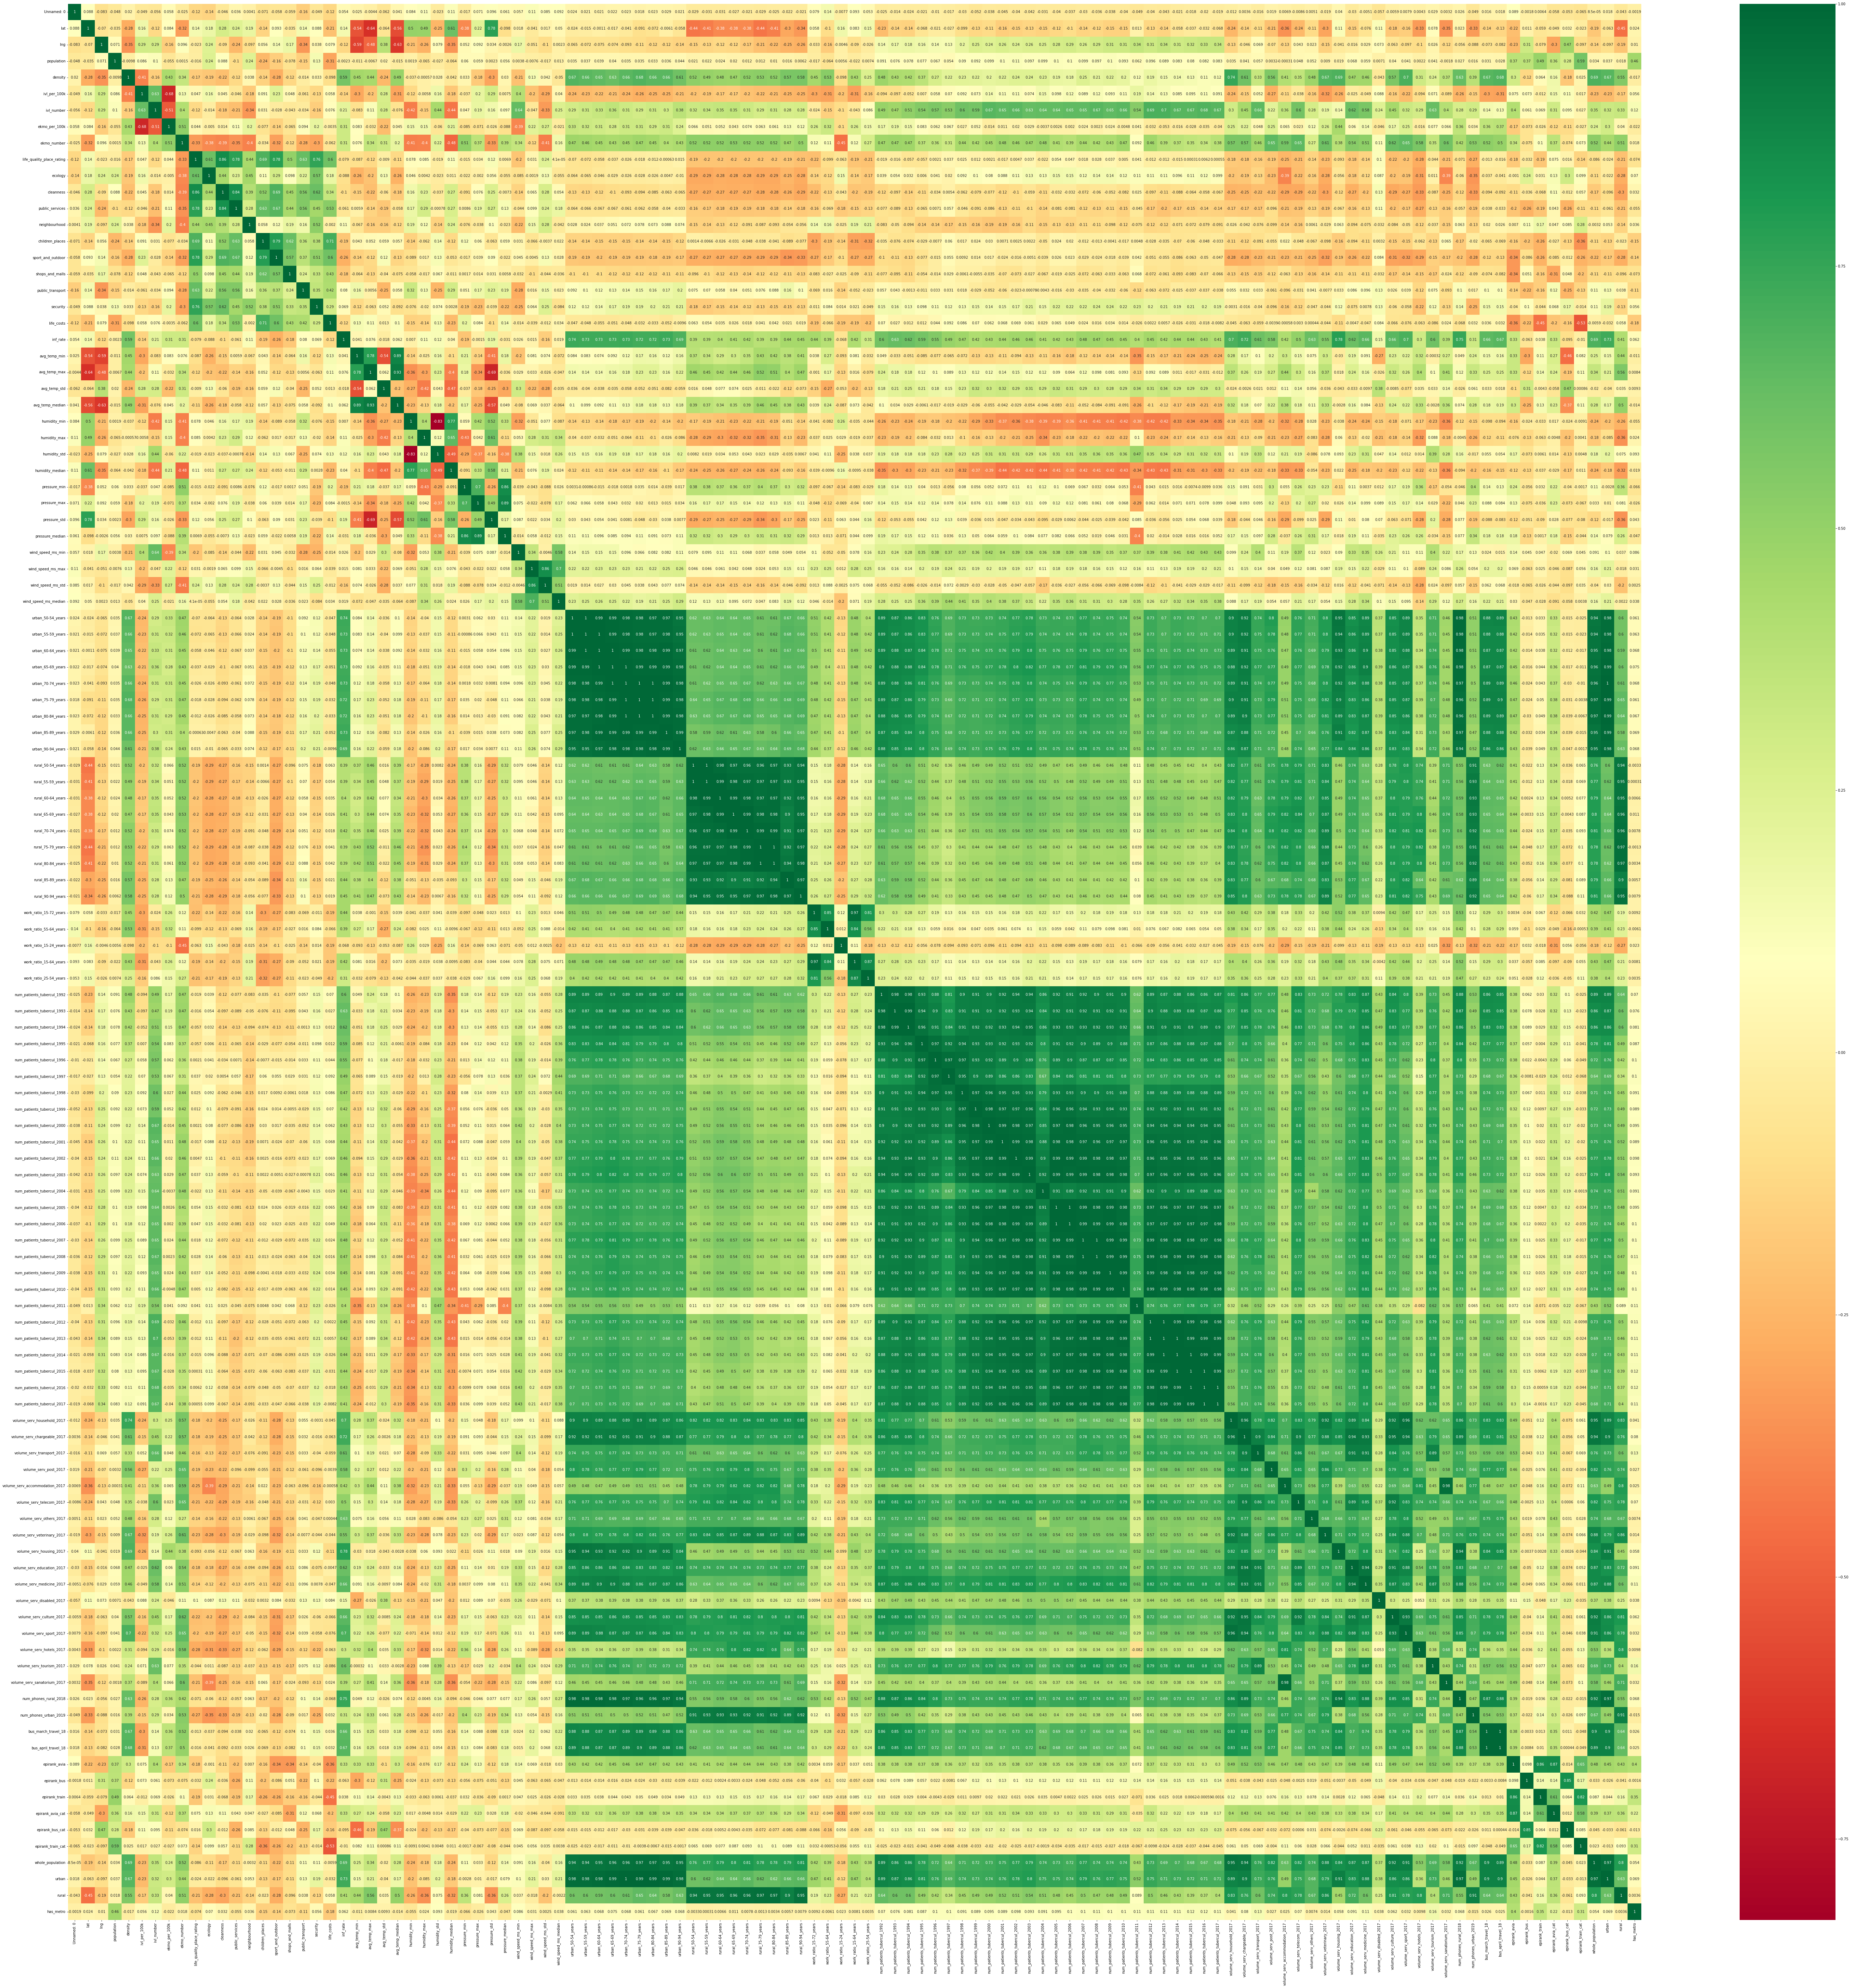

In [27]:
cor = compute_correlation(data2)
cor

## После отбора и изменения признаков

population   density  ivl_per_100k  \
population                        1.000000  0.203427      0.046112   
density                           0.203427  1.000000      0.265150   
ivl_per_100k                      0.046112  0.265150      1.000000   
avg_temp_median                   0.080472  0.725970      0.453293   
humidity_median                   0.154146  0.106899      0.156594   
pressure_median                   0.177015  0.088692      0.014239   
wind_speed_ms_median              0.039049  0.169639      0.147269   
work_ratio_15-72_years            0.001942  0.354356      0.191653   
work_ratio_15-24_years            0.111072  0.102165      0.034692   
volume_serv_household_2017        0.275470  0.466418      0.023708   
volume_serv_chargeable_2017       0.178235  0.022529      0.169413   
volume_serv_accommodation_2017    0.129768  0.069157      0.214973   
volume_serv_medicine_2017         0.148516  0.029634      0.135529   
volume_serv_disabled_2017         0.161071  0.580927      0.159048   
volume_serv_sport_2017            0.147424  0.096287      0.029689   
volume_serv_hotels_2017           0.032647  0.039286      0.066830   
volume_serv_tourism_2017          0.069047  0.183461      0.201361   
volume_serv_sanatorium_2017       0.114269  0.014466      0.243199   
bus_march_travel_18               0.231170  0.343085      0.048622   
epirank_bus                       0.088383  0.304464      0.150661   
whole_population                  0.222147  0.458433      0.036683   
urban                             0.025074  0.129351      0.111446   
has_metro                         0.085855  0.005302      0.068743   
urban50over_share                 0.011228  0.203293      0.138195   
tubercul_share                    0.000257  0.503910      0.190040   

                                avg_temp_median  humidity_median  \
population                             0.080472         0.154146   
density                                0.725970         0.106899   
ivl_per_100k                           0.453293         0.156594   
avg_temp_median                        1.000000         0.046519   
humidity_median                        0.046519         1.000000   
pressure_median                        0.053112         0.057588   
wind_speed_ms_median                   0.053756         0.188235   
work_ratio_15-72_years                 0.099144         0.058729   
work_ratio_15-24_years                 0.160411         0.093901   
volume_serv_household_2017             0.161925         0.453687   
volume_serv_chargeable_2017            0.240049         0.271614   
volume_serv_accommodation_2017         0.242934         0.207439   
volume_serv_medicine_2017              0.285939         0.096706   
volume_serv_disabled_2017              0.347266         0.030221   
volume_serv_sport_2017                 0.213003         0.118479   
volume_serv_hotels_2017                0.151914         0.090072   
volume_serv_tourism_2017               0.438225         0.112479   
volume_serv_sanatorium_2017            0.270494         0.193330   
bus_march_travel_18                    0.065782         0.336725   
epirank_bus                            0.342057         0.122793   
whole_population                       0.180039         0.396423   
urban                                  0.382040         0.067653   
has_metro                              0.029054         0.037119   
urban50over_share                      0.376975         0.179219   
tubercul_share                         0.604404         0.340710   

                                pressure_median  wind_speed_ms_median  \
population                             0.177015              0.039049   
density                                0.088692              0.169639   
ivl_per_100k                           0.014239              0.147269   
avg_temp_median                        0.053112              0.053756   
humidity_median                        0.057588              0.188235   
pres

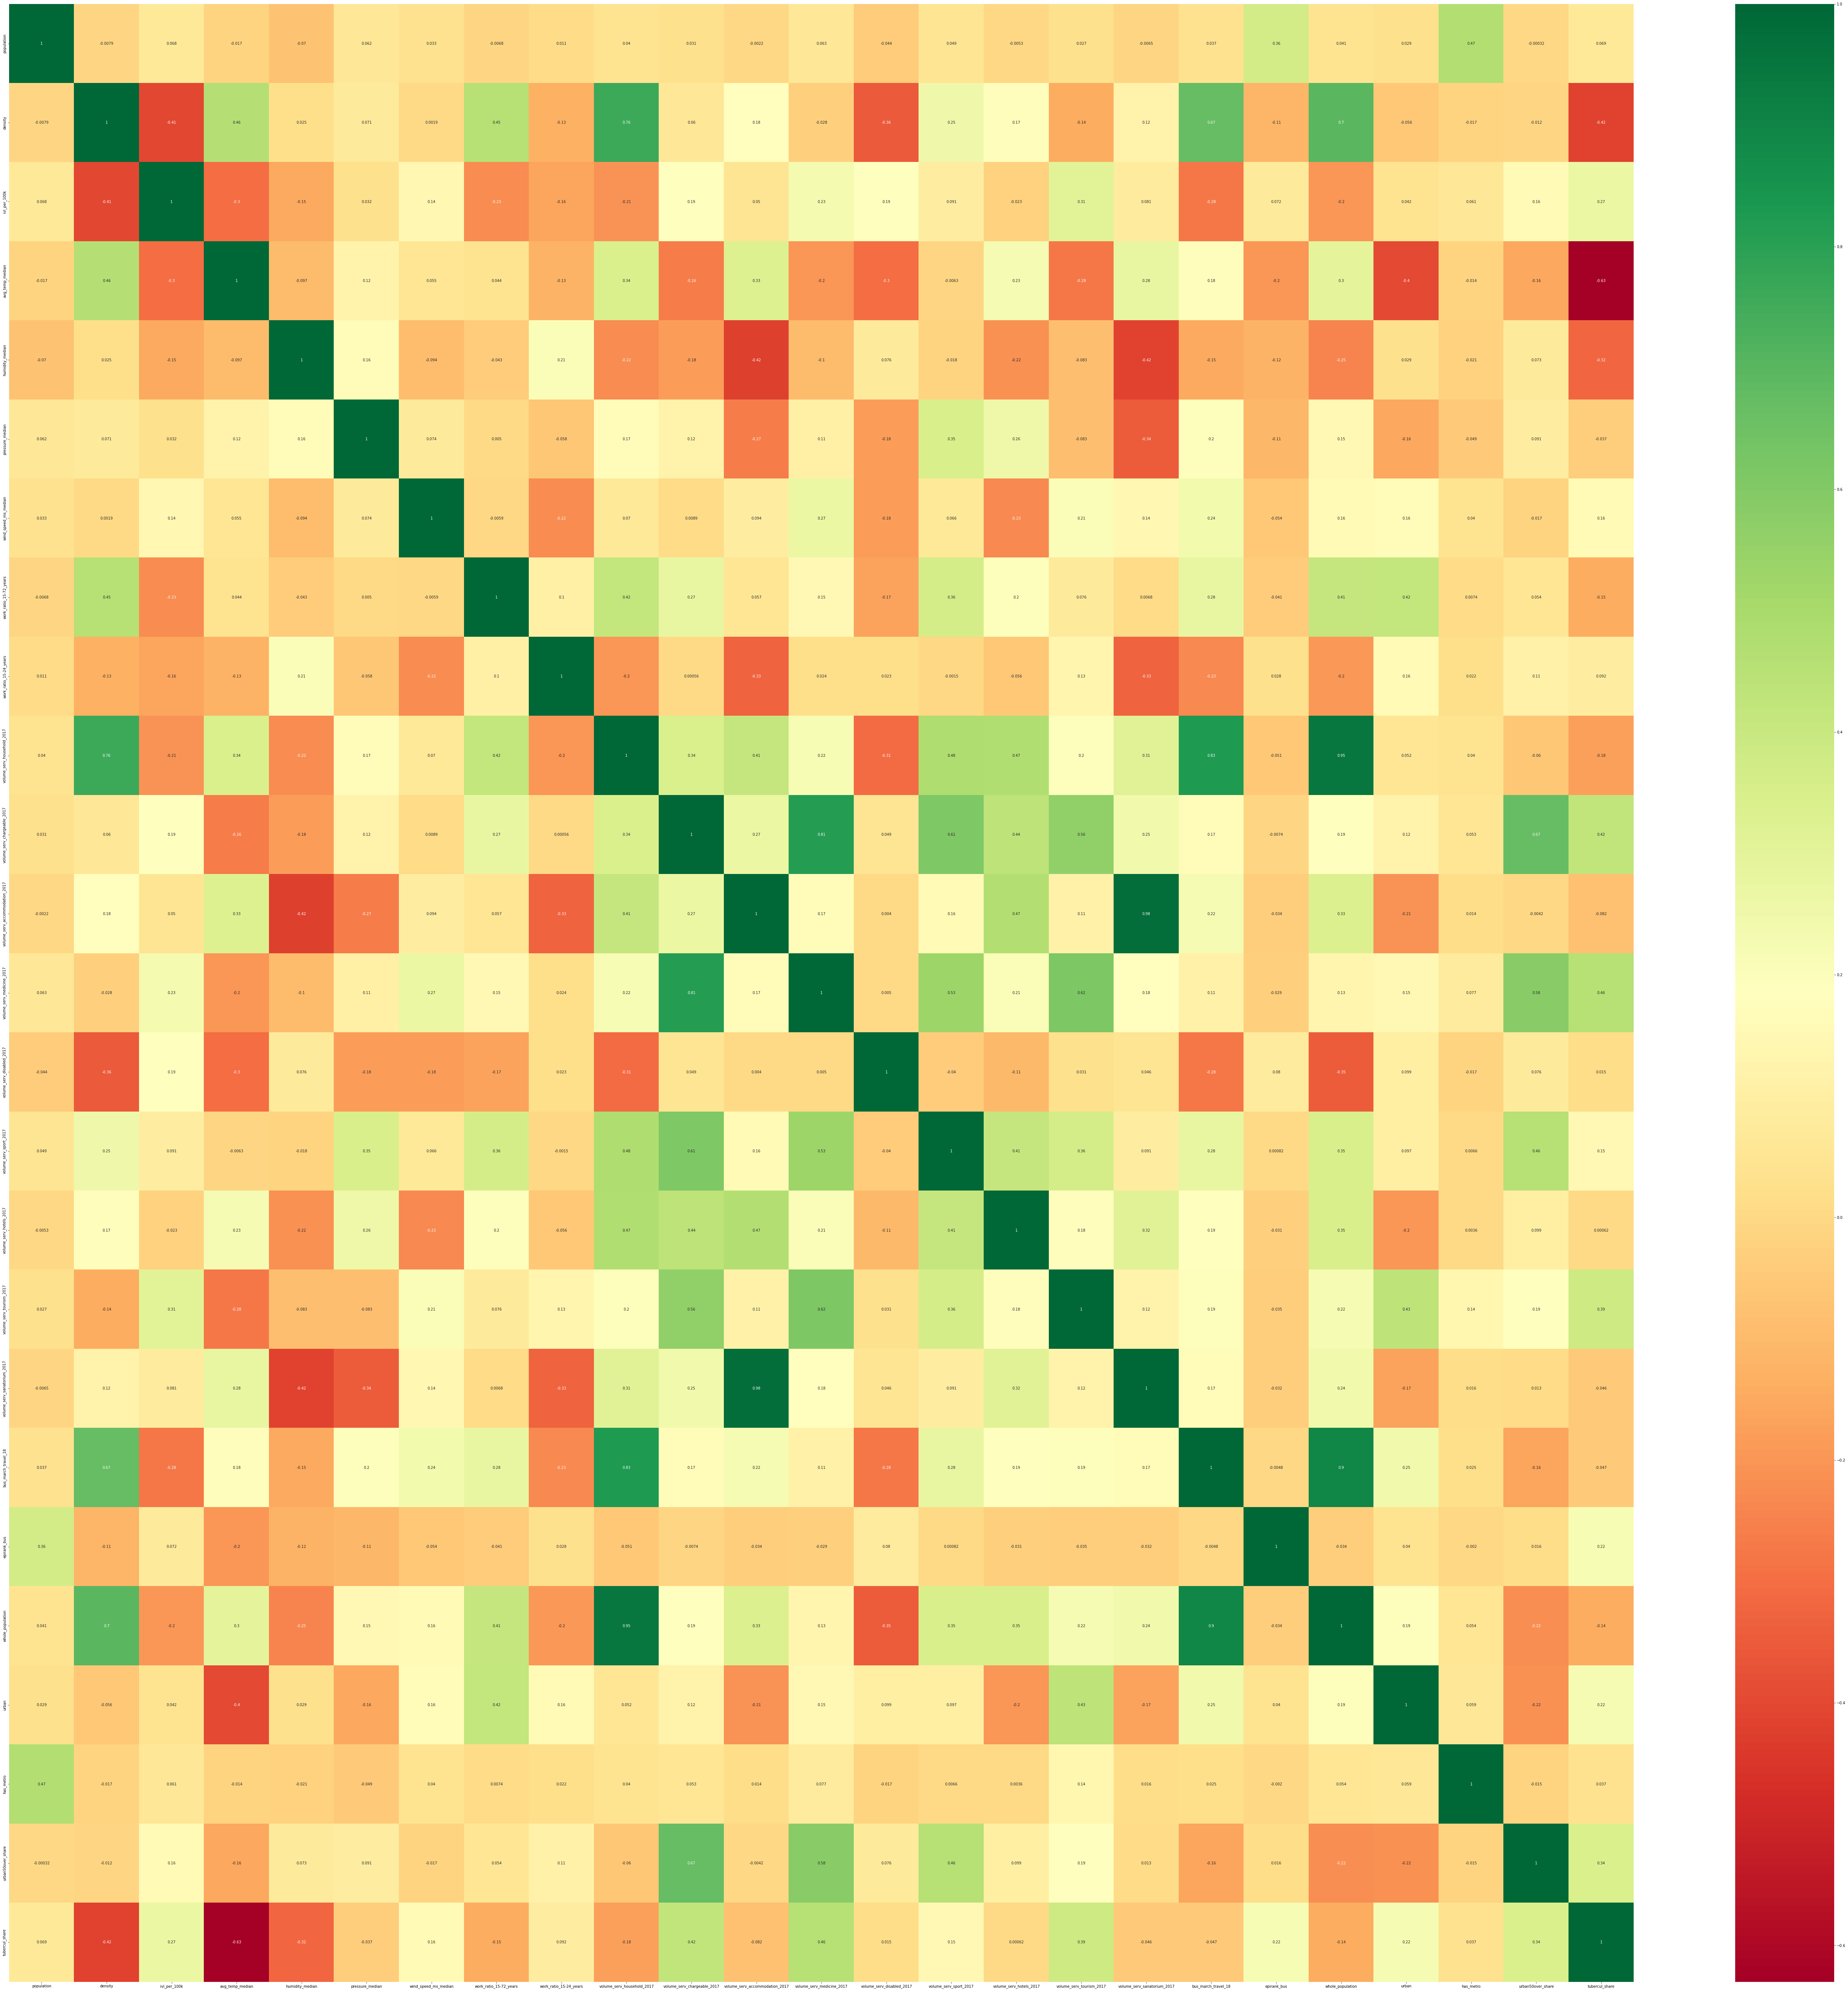

In [28]:
cor = compute_correlation(X2)
cor

## SVD-разложение матрицы признаков

In [14]:
_, d, _ = np.linalg.svd(X_val.drop(['region_x'], axis='columns'), full_matrices=False)

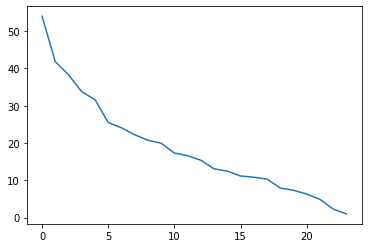

In [16]:
plt.plot(d[1:])

# Линейная регрессия с LASSO-регуляризацией

In [22]:
mae = 0
mape = 0
n = 20
for rs in range(n):
  X_train, X_test, Y_train, Y_test = train_test_split(X2dum, y2, train_size = 0.9, random_state=rs+40)

  model = Lasso(alpha = 1e-5)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  mae += mean_absolute_error(Y_pred, Y_test)
  mape += mean_absolute_percentage_error(Y_pred, Y_test)
print("MAE =", mae / n)
print("MAPE =", mape / n)
model.coef_


model = Lasso(alpha = 1e-5)
model.fit(X2dum, y2)
Y_val = model.predict(Xvaldum)
Y_val


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.021e-02, tolerance: 3.120e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.797e-02, tolerance: 3.214e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

MAE = 0.007898887691179251
MAPE = 0.005508894880225051


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.401e-02, tolerance: 3.051e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e-01, tolerance: 3.618e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


array([  2.70776713,   0.69397744,   0.6938524 ,   1.62156326,
         1.38699648,   1.79311027,   2.07843893,   1.38682292,
         0.69385191,   1.09904104,   1.79244492,   2.70776714,
         2.70776714,   1.38682292,   2.70773899,   3.13448496,
         1.09902122,   1.95805304,   2.70779965,   2.70773766,
         2.07903453,   2.07887909,   2.07357075,   2.07341531,
         2.78343936,   1.78973294,   1.6212562 ,   3.21871425,
         1.95805308,   1.38832271,   4.71872759,   1.61044865,
         1.09902122,   1.38832268,   1.38682291, 578.84073988,
         2.56415571,   1.79117548,   1.099041  ,   1.38766039,
         0.69385222,   4.71872614,   2.70776703,   2.39798338,
         2.70779428,   1.3883383 ,   1.96016022,   4.71872614,
         1.96015878,   1.11150059,   2.30124067,   1.95805306,
         3.21871423,   1.60915824,   0.69397598,   2.78343936,
         1.79244491,   1.95805308,   1.79311025,   0.69397598,
         1.79310991,   2.70776712,   1.09905851,   3.21

Несмотря на хорошее среднее значение MAE при кросс-валидации, на закрытом тесте в некоторых случаях выдаёт огромные и явно неправдоподобные значения порядка некольких сотен. Поэтому модель использовать не будем.

# SVR с Гауссовым ядром

In [25]:
mae = 0
mape = 0
n = 20
for rs in range(n):
  X_train, X_test, Y_train, Y_test = train_test_split(X2dum, y2, train_size = 0.9, random_state=rs+40)

  model = SVR(kernel = 'rbf',  C=42)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  mae += mean_absolute_error(Y_pred, Y_test)
  mape += mean_absolute_percentage_error(Y_pred, Y_test)
print("MAE =", mae / n)
print("MAPE =", mape / n)

MAE = 0.11177167727065199
MAPE = 0.06722956587356874


# XGBoost

In [24]:
mae = 0
mape = 0
n = 20
for rs in range(n):
  X_train, X_test, Y_train, Y_test = train_test_split(X2dum, y2, train_size = 0.9, random_state=rs+40)

  model = XGBRegressor()
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  mae += mean_absolute_error(Y_pred, Y_test)
  mape += mean_absolute_percentage_error(Y_pred, Y_test)
print("MAE =", mae / n)
print("MAPE =", mape / n)

[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# BaggingRegressor

In [23]:
mae = 0
mape = 0
n = 20
for rs in range(n):
  X_train, X_test, Y_train, Y_test = train_test_split(X2dum, y2, train_size = 0.9, random_state=rs+40)

  model = BaggingRegressor()
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)
  mae += mean_absolute_error(Y_pred, Y_test)
  mape += mean_absolute_percentage_error(Y_pred, Y_test)
print("MAE =", mae / n)
print("MAPE =", mape / n)

MAE = 0.04646557294392109
MAPE = 0.03000302057551559


# CatBoost

In [199]:
data2 = pd.read_csv("covid_data_train.csv")
y2, data2, _, _ = data_preprocess(data2)

mae = 0
mape = 0
n = 2
for rs in range(n):
  cat_features = ['region_x']
  X_train, X_test, Y_train, Y_test = train_test_split(data2, y2, train_size = 0.9, random_state=rs+40)
  train_dataset = cb.Pool(X_train, Y_train, cat_features = cat_features) 
  test_dataset = cb.Pool(X_test, Y_test, cat_features=cat_features)
  #number = X_train.columns.get_loc('region_x')
  model = cb.CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)
  """grid = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [0.5, 1]}
  model.grid_search(grid, train_dataset)"""
  model.fit(X_train, Y_train, verbose=False)
  Y_pred = model.predict(X_test)
  mae += mean_absolute_error(Y_pred, Y_test)
  mape += mean_absolute_percentage_error(Y_pred, Y_test)
print("MAE =", mae / n)
print("MAPE =", mape / n)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


MAE = 0.040538949641464025
MAPE = 0.029082914325002568


0.025795008500979398

Text(0.5, 0, 'CatBoost Feature Importance')

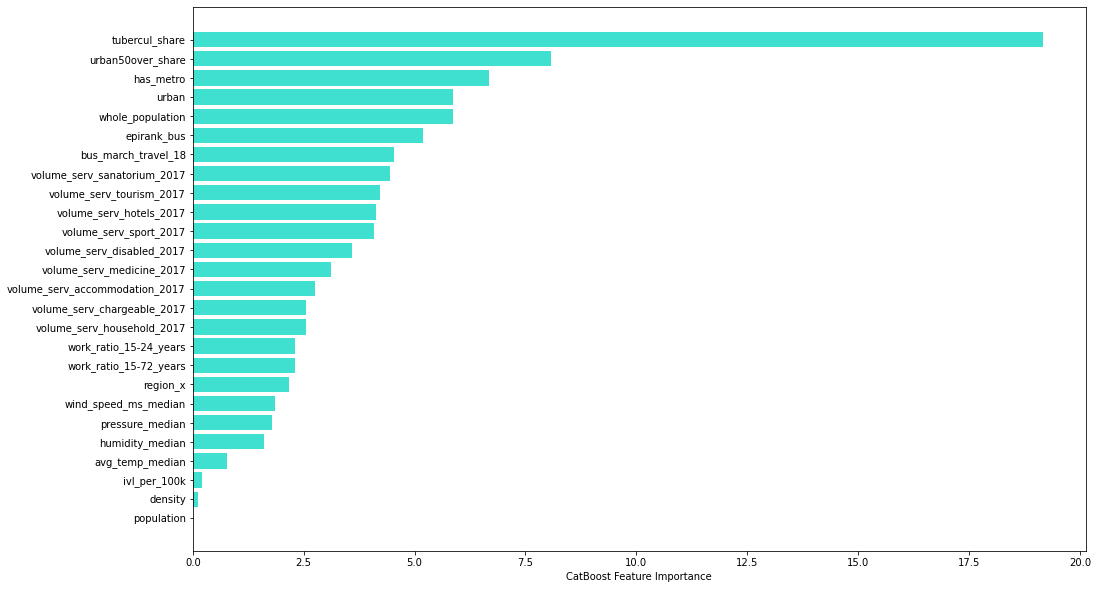

In [158]:
model = cb.CatBoostRegressor(loss_function='RMSE', cat_features=cat_features)
model.fit(data2, y2, verbose=False)
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(16,10))
plt.barh(data2.columns, 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

# Перцептрон

Для получения хорошего результата требуется более точная настройка параметров.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X2dum, y2, train_size = 0.9, random_state=42)
input_dim = len(X_test.columns)

model = Sequential([
    Dense(50, input_dim = input_dim, activation = 'relu'),
    Dense(1, activation = 'relu')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test),
                    epochs = 120, batch_size = 32)
test_loss, test_acc = model.evaluate(X_test, Y_test)

Epoch 1/120
12/12 [==============================] - 1s 25ms/step - loss: 1.0141 - mae: 0.8016 - val_loss: 0.9847 - val_mae: 0.7442
Epoch 2/120
12/12 [==============================] - 0s 5ms/step - loss: 0.9652 - mae: 0.7719 - val_loss: 0.9347 - val_mae: 0.7159
Epoch 3/120
12/12 [==============================] - 0s 5ms/step - loss: 0.8962 - mae: 0.7232 - val_loss: 0.8829 - val_mae: 0.6670
Epoch 4/120
12/12 [==============================] - 0s 6ms/step - loss: 0.8655 - mae: 0.6793 - val_loss: 0.8719 - val_mae: 0.6510
Epoch 5/120
12/12 [==============================] - 0s 5ms/step - loss: 0.8514 - mae: 0.6661 - val_loss: 0.8651 - val_mae: 0.6405
Epoch 6/120
12/12 [==============================] - 0s 5ms/step - loss: 0.8415 - mae: 0.6533 - val_loss: 0.8649 - val_mae: 0.6394
Epoch 7/120
12/12 [==============================] - 0s 5ms/step - loss: 0.8366 - mae: 0.6404 - val_loss: 0.8621 - val_mae: 0.6317
Epoch 8/120
12/12 [==============================] - 0s 5ms/step - loss: 0.8348 - 